<a href="https://colab.research.google.com/github/advset/Using-Keras-to-Classify-Image/blob/master/Belajar_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

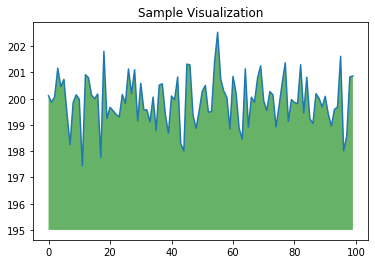

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)

plt.title("Sample Visualization")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from PIL import Image
import pathlib

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
import skimage
import skimage.color

from skimage.feature import hog

import joblib #to store model
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
 
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
 
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
 
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
 
    xtemp = np.arange(len(unique))
 
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
    

data_list = []
label_list = []

#data_np = np.zeros((1,60,100,4))
data_np = np.zeros((1,60,100,3))
#data_np = np.zeros((1,120,200,3))
label = "Non-Covid"
label_list.append(label)

for path in pathlib.Path("/content/drive/My Drive/Colab Notebooks/CT_NonCOVID_resized").iterdir():
    if path.is_file():
        #data = Image.open(path, "r")
        data = Image.open(path)
        #data = mpimg.imread(str(path))
        #data =data.resize((100,60),Image.ANTIALIAS)
        data = np.array(data)
        #data_list.append(data)
        data_np = np.append(data_np, np.expand_dims(data, axis = 0), axis = 0)
        label = "Non-Covid"
        label_list.append(label)
         

for path in pathlib.Path("/content/drive/My Drive/Colab Notebooks/CT_COVID_resized").iterdir():
    if path.is_file():
        #data = Image.open(path, "r")
        data = Image.open(path)
        #data = mpimg.imread(str(path))
        #data =data.resize((100,60),Image.ANTIALIAS)
        data = np.array(data)
        #data_list.append(data)
        data_np = np.append(data_np, np.expand_dims(data, axis = 0), axis = 0)
        label = "Covid"
        label_list.append(label)

#X = np.array(data_list)
#y = np.array(label_list)
X = data_np
y = np.array(label_list)
        
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=42,
)

#seeing data
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)),
    'test ({0} photos)'.format(len(y_test))
]);

# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(8, 8),
    cells_per_block=(2,2),
    orientations=9,
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
#X_train_prepared = scalify.fit_transform(np.asarray(X_train_hog))
 
print(X_train_prepared.shape)

# training
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

# testing
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

# save the model to disk
filename = 'SGD_'+str(int(100*np.sum(y_pred == y_test)/len(y_test)))+'%accuracy.sav'
joblib.dump(sgd_clf, filename)


FileNotFoundError: ignored

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks"

'Belajar Keras.ipynb'   CT_COVID_resized   CT_NonCOVID_resized
